## Explore Instacart Shopper Behaviors

In [1]:
# common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Data Analysis and Preprocessing

### A. Datasets Information

In [2]:
# load csv data
aisles = pd.read_csv('/Users/Nicole/Desktop/raw/aisles.csv')
dept = pd.read_csv('/Users/Nicole/Desktop/raw/departments.csv')
prod = pd.read_csv('/Users/Nicole/Desktop/raw/products.csv')
train = pd.read_csv('/Users/Nicole/Desktop/raw/order_products__prior.csv')
test = pd.read_csv('/Users/Nicole/Desktop/raw/order_products__train.csv')
orders = pd.read_csv('/Users/Nicole/Desktop/raw/orders.csv')

In [3]:
# shape of datasets
df = [aisles, dept, prod, train, test, orders]
df_names = ['aisles','dept','prod','train','test','orders']

for i in range(6):
    shape = df[i].shape
    name = df_names[i]
    print('shape of "{}": '.format(name), shape)

shape of "aisles":  (134, 2)
shape of "dept":  (21, 2)
shape of "prod":  (49688, 4)
shape of "train":  (32434489, 4)
shape of "test":  (1384617, 4)
shape of "orders":  (3421083, 7)


In [5]:
# columns names in datasets
for i in range(6):
    col = df[i].columns.values
    name = df_names[i]
    # print('columns in "{}": '.format(name), col)
    print(col)

['aisle_id' 'aisle']
['department_id' 'department']
['product_id' 'product_name' 'aisle_id' 'department_id']
['order_id' 'product_id' 'add_to_cart_order' 'reordered']
['order_id' 'product_id' 'add_to_cart_order' 'reordered']
['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


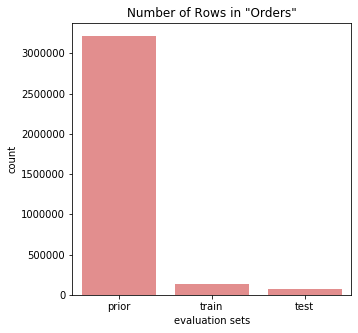

In [6]:
# Subset "orders" by evaluation set
plt.figure(figsize=(5,5))
sns.barplot(orders.eval_set.unique(), orders.eval_set.value_counts(), color='lightcoral')
plt.title('Number of Rows in "Orders"', size =12)
plt.xlabel('evaluation sets')
plt.ylabel('count')
plt.show()

order_prior = orders.loc[orders['eval_set'] == 'prior']
order_train = orders.loc[orders['eval_set'] == 'train']
order_test = orders.loc[orders['eval_set'] == 'test']

In [7]:
# find out unique customers
order_prior_uniqueuser = len(np.unique(order_prior.user_id))
order_train_uniqueuser = len(np.unique(order_train.user_id))
order_test_uniqueuser = len(np.unique(order_test.user_id))
print('Unique Users in Prior Set:', order_prior_uniqueuser)  
print('Unique Users in Train Set:', order_train_uniqueuser)
print('Unique Users in Test Set:', order_test_uniqueuser)

Unique Users in Prior Set: 206209
Unique Users in Train Set: 131209
Unique Users in Test Set: 75000


### B. Customer Clustering

In [8]:
# clustering imports
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [9]:
data = pd.merge(pd.merge(pd.merge(train, prod, on="product_id"),\
                                  orders, on="order_id"), aisles, on="aisle_id")
data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs


In [12]:
data_user_dept = pd.crosstab(data['user_id'], data['department_id'])
data_user_dept.head()

department_id,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,13,0,0,0,...,0,1,3,0,13,2,0,22,0,0
2,17,0,2,36,0,3,9,0,0,0,...,1,11,3,1,48,0,0,42,21,0
3,6,0,0,38,0,0,3,0,4,0,...,0,4,0,0,21,1,0,9,2,0
4,3,0,2,2,2,0,3,0,0,0,...,0,0,0,1,0,2,0,1,2,0
5,2,0,0,19,0,2,0,0,1,0,...,0,2,0,1,8,0,0,1,1,0


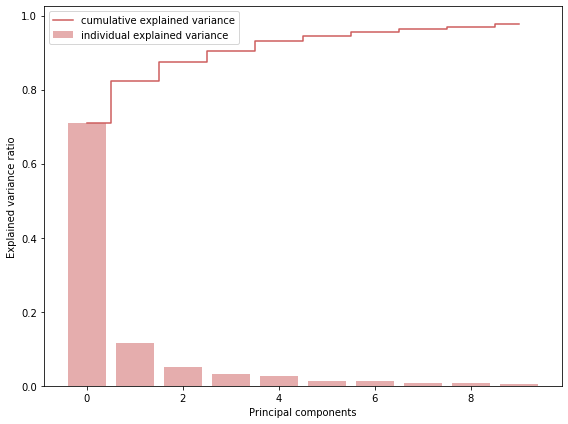

In [13]:
# PCA on clusters

pca = PCA(n_components=10)
pca.fit(data_user_dept)
pca_samples = pca.transform(data_user_dept)

cumsum = np.cumsum(pca.explained_variance_ratio_)
var_exp = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(10), var_exp, alpha=0.5, align='center', label='individual explained variance', color='indianred')
plt.step(range(10), cumsum, where='mid', label='cumulative explained variance', color='indianred')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [15]:
cumsum

array([0.70879925, 0.82436384, 0.87434953, 0.90550666, 0.93136086,
       0.94403183, 0.95608054, 0.96383181, 0.97032379, 0.9759194 ])

In [16]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9
0,-42.639967,13.919004,-6.833286,-3.396528,11.980358,1.653829,-2.046632,-2.620817,0.016671,-0.768658
1,6.708748,28.831181,4.381061,-20.681325,9.361615,-0.773940,-8.733777,4.292725,-7.863553,10.817624
2,-14.243010,-7.970956,5.043642,-2.406434,5.607158,1.200488,-4.732903,-2.676969,-0.198070,0.712688
3,-55.654405,-4.908788,-0.330543,0.115333,0.225723,0.867168,-0.804004,2.208241,1.188385,0.746714
4,-38.571140,-11.077100,4.303457,-0.385742,3.704085,0.774572,-1.911910,-0.494770,-0.772473,0.103836


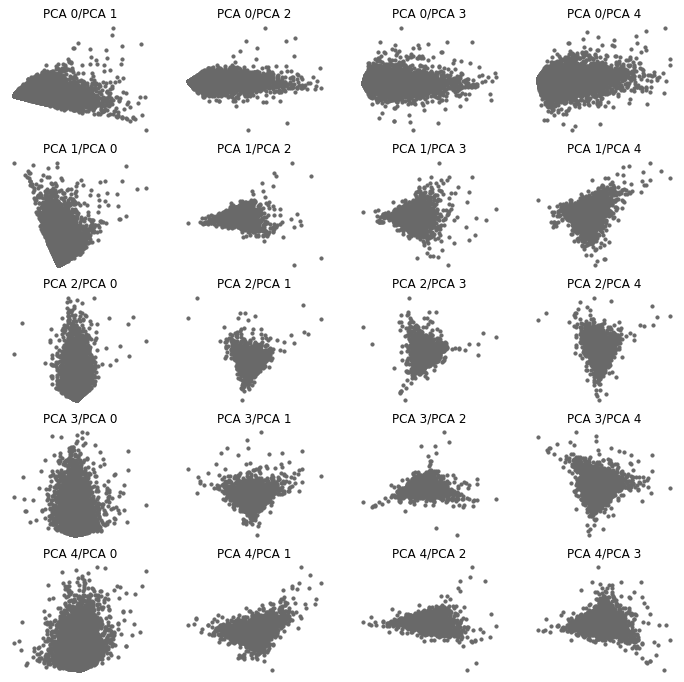

In [17]:
plt.figure(figsize=(12,12))

i=1
for column1 in range(0,5):
    for column2 in range(0,5):
        if column1!=column2:
            ax = plt.subplot(5,4,i)
            ax.scatter(ps[column1], ps[column2], c='dimgrey', s=10)
            plt.axis('off')
            plt.title('PCA {}/PCA {}'.format(column1,column2))
            i+=1
        
plt.show()

No obvious cluster separation. Try with 3 dimensions, using the first 3 PCA components.

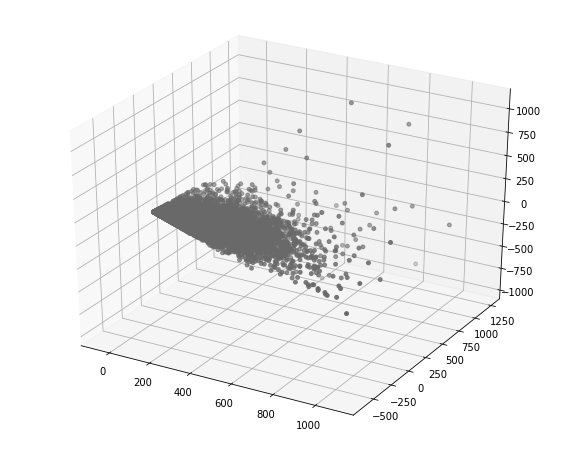

In [18]:
pca3d = plt.figure(figsize=(10, 8))
ax = pca3d.add_subplot(111, projection='3d')

ax.scatter(ps[0], ps[1], ps[2], c='dimgray', s=15)
plt.show()

Not clear yet. Try with all the 10 PCA components to capture 96% of the variance.

In [20]:
# reduce the matrix for the sake of memory
matDendogram = ps[:10000]

In [22]:
link_mat = linkage(matDendogram, 'ward')
print(link_mat.shape)
clusters = fcluster(link_mat, 10, criterion='maxclust')

(9999, 4)


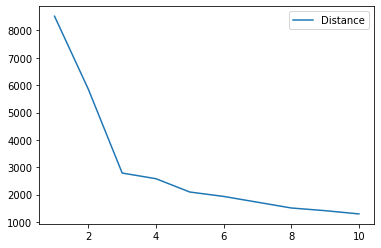

In [41]:
# 'elbow' method for hierarchical clustering
last_merges = link_mat[-10:, 2]
last_merges_rev = last_merges[::-1]
idx = np.arange(1, len(last_merges) + 1)
plt.plot(idx, last_merges_rev, label='Distance')
plt.legend()
plt.show()

In [23]:
# find the distance at which to cut off the dendrogram for a given number of clusters
def findDendrogramCut(ddata, n_cluster):
    hierarch_dist = np.matrix(ddata['dcoord'])
    sorted_hierarch_dist = hierarch_dist[np.argsort(hierarch_dist.A[:,1])]
    d_cut = sorted_hierarch_dist[-n_cluster:-n_cluster+2][:,1].sum() / 2.
    return d_cut

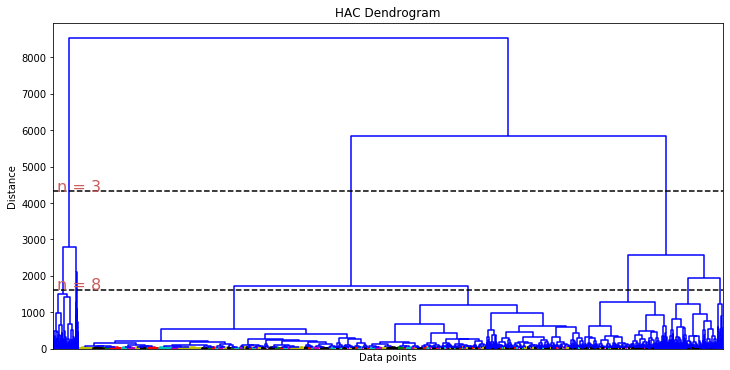

In [48]:
# plotting a dendrogram
plt.figure(figsize=(12,6))

ddata = dendrogram(link_mat, leaf_rotation=90., no_labels=True, color_threshold=50)
# gap for 3 clusters
dist_cut1 = findDendrogramCut(ddata, 3)
plt.axhline(y=dist_cut1, linestyle='--', c='k')
plt.text(np.min(ddata['icoord'])*100, dist_cut1, 'n = 3', size=16, color='indianred')
# gap for 8 clusters
dist_cut2 = findDendrogramCut(ddata, 8)
plt.axhline(y=dist_cut2, linestyle='--', c='k')
plt.text(np.min(ddata['icoord'])*100, dist_cut2, 'n = 8', size=16, color='indianred')

plt.title('HAC Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

There is a clear distance gap for 3 clusters, but probably 8 clusters work based on the dendogram picture.

#### KMeans clusters

In [50]:
# final decision on 5 clusters
clusterer = KMeans(n_clusters=5).fit(ps)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(ps)

In [51]:
orders['cluster'] = orders.apply(lambda row: c_preds[row.user_id-1], axis=1)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2539329,1,prior,1,2,8,NaN,0
1,2398795,1,prior,2,3,7,15.0,0
2,473747,1,prior,3,3,12,21.0,0
3,2254736,1,prior,4,4,7,29.0,0
4,431534,1,prior,5,4,15,28.0,0


In [52]:
orders.to_csv('/Users/Nicole/Desktop/raw/orders_clustered.csv', index_label=False)